# ISA Learn Delta

**Motivation:** This is almost identical to the `ISA-Learn-Delta` notebook, except we're going to start from some weights that we _knew_ to be good from a pretrained model from `Invariant-Slot-Attention`.

In [1]:
import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mlp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import json, yaml, os
os.sys.path.append('../code')

from model import InvariantSlotAttention
from plotting import plot_chosen_slots
from data import make_batch
from torch.nn import init
from train import hungarian_matching, train

import torch
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

In [2]:
device='cuda:0'
hps = {
    'hidden_dim': 16,
    'k_slots':3,
    'query_dim':128,
    'pixel_mult':0.2,
    'device':device
}

In [3]:
m = InvariantSlotAttention(**hps).to(device)

In [4]:
cID_prev = 'isa-cosine-decay'
lastIter = 39_000
modelToLoad = f'../code/models/{cID_prev}/m_{lastIter}.pt'
m.load_state_dict(torch.load(modelToLoad,map_location=device),strict=False)

_IncompatibleKeys(missing_keys=['final_mlp.0.weight', 'final_mlp.0.bias', 'final_mlp.2.weight', 'final_mlp.2.bias'], unexpected_keys=[])

In [5]:
# Invaraint Slot Attention, Hyper Graph, warm start
cID = 'isa-hg-warm'

modelDir = f'../code/models/{cID}'
figDir = f'../code/figures/{cID}'


In [8]:
def train(model, 
          Ntrain = 5000, 
          bs=32, 
          lr=3e-4,
          warmup_steps=5_000,
          alpha=1,
          losses = {'tot':[],'bce':[],'mse':[]},
          kwargs={'isRing': True, 'N_clusters':2},
          device='cpu',
          plot_every=250, 
          save_every=1000,
          color='C0',cmap='Blues',
          modelDir='.',figDir='',showImg=True):
    '''
    train -- arguments copied from Lukas's fct (see train.py)
    '''

    # Learning rate schedule config
    base_learning_rate = lr
    
    opt = torch.optim.Adam(model.parameters(), base_learning_rate)
    model.train()
    
    k_slots = model.k_slots
    max_n_rings = kwargs['N_clusters']
    resolution = model.resolution
    kwargs['device'] = device

    start = len(losses)
    for i in range(start,start+Ntrain):

        learning_rate = base_learning_rate * 0.5 * (1 + np.cos(np.pi * i / Ntrain))
        if i < warmup_steps:
            learning_rate *= (i / warmup_steps)
        
        opt.param_groups[0]['lr'] = learning_rate
        
        X, Y, mask = make_batch(N_events=bs, **kwargs)
        
        queries, att, Y_pred = model(X)
         
        # Reshape the target mask to be flat in the pixels (same shape as att)
        flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
        with torch.no_grad():
            
            pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
            indices = hungarian_matching(pairwise_cost)

        # Apply the sorting to the predict
        bis=torch.arange(bs).to(device)
        indices=indices.to(device)

        # Loss calc
        slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()
        
        Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
        Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

        l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()
    
        # Calculate the loss
        li = l_bce + alpha*l_mse
        
        li.backward()
        clip_val=1
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_val)
        
        opt.step()
        opt.zero_grad()

        losses['tot'].append(float(li))
        losses['bce'].append(float(l_bce))
        losses['mse'].append(float(l_mse))
        
        if i % plot_every == 0:
            print('iter',i,', loss',li.detach().cpu().numpy(),', lr',opt.param_groups[0]['lr'])  
            iEvt = 0

            # losses, mask, att_img, Y_true, Y_pred
            plot_chosen_slots(losses,
                              mask[iEvt].sum(axis=0), 
                              slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                              Y_true_sorted[iEvt],
                              Y_pred_sorted[iEvt])
            
        if (i % save_every == 0) and modelDir:
            torch.save(model.state_dict(), f'{modelDir}/m_{i}.pt')
            with open(f'{modelDir}/loss.json','w') as f:
                json.dump(losses, f)

    model.eval()
    return model,losses

In [9]:
m, losses = train(m, bs=256, Ntrain=5_000, warmup_steps=1_000,
                  plot_every=100, device=device,
                  modelDir=modelDir, figDir=figDir)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


NameError: name 'comb_loss' is not defined

In [16]:
with open('../code/models/isa-hg-warm/loss.json') as f:
    l_alpha = pd.DataFrame(json.load(f))

In [64]:
with open('../code/models/isa-hung-bce/loss.json') as f:
    l_bce_hung = pd.DataFrame(json.load(f))

In [65]:
len(l_bce_hung)

4998

Text(0, 0.5, 'Loss')

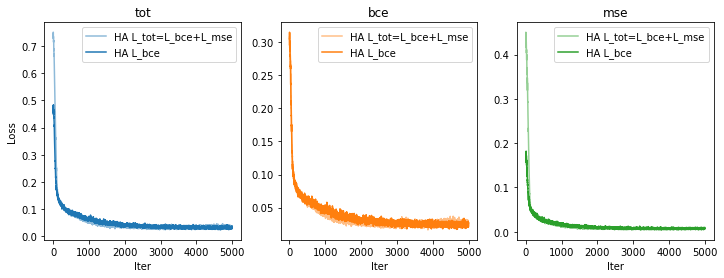

In [66]:
fig, axs = plt.subplots(1,3,figsize=(12,4))

for i,k,ax in zip(range(3),['tot','bce','mse'],axs):
    
    ax.plot(l_alpha[k],color=f'C{i}',alpha=.5,label='HA L_tot=L_bce+L_mse')
    ax.plot(l_bce_hung[k],color=f'C{i}',label='HA L_bce')
    
    ax.set_title(k)
    ax.set_xlabel('Iter')
    ax.legend()
axs[0].set_ylabel('Loss')

I had originally forgotten to save the model and figures, so I'll try saving them now :)

In [22]:
torch.save(m.state_dict(), f'{modelDir}/m_5000.pt')
with open(f'{modelDir}/loss.json','w') as f:
    json.dump(losses, f)

**Notes:**
- This loss seems lower than it was before (which I'm _super_ happy about).
- However, maybe I should do the Hungarian matching just based on the ...

In [28]:
pd.Series(losses['bce']).rolling(100).mean().tail()

4995    0.025876
4996    0.025843
4997    0.025855
4998    0.025839
4999    0.025855
dtype: float64

**Goal:** Let's try to compare these predictions on the same 100 examples that I was looking at in the `KL-divergence` notebook.

In [86]:
# Set numpy seed for test set sampling 
# np.random.seed(24082023)

# torch_seed = 29082023
# torch.manual_seed( torch_seed )

# import random
# random.seed(torch_seed)

In [87]:
bs = 100
kwargs={'isRing': True, 'N_clusters':2} #, 'device':device}

X,Y, mask = make_batch(N_events=bs, **kwargs)

/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/Notebooks/../code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)


In [88]:
max_n_rings = kwargs['N_clusters']
k_slots=max_n_rings+1
resolution=(32,32)

In [89]:
alpha=1

In [90]:
# with torch.no_grad():

#     queries, att, Y_pred = m(X)
         
#     # Reshape the target mask to be flat in the pixels (same shape as att)
#     flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      

#     pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
#     indices = hungarian_matching(pairwise_cost)

#     # Apply the sorting to the predict
#     bis=torch.arange(bs).to(device)
#     indices=indices.to(device)

#     # Loss calc
#     slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
#     rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
#     l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

#     Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
#     Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

#     l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()


In [91]:
m.device='cpu'
m = m.to('cpu')

In [92]:
hps['device'] = 'cpu'

In [99]:
m2 = InvariantSlotAttention(**hps)
m2.load_state_dict(torch.load(f'{modelDir}/m_5000.pt',map_location='cpu'))

<All keys matched successfully>

In [100]:
queries, att, Y_pred = m2(X)

In [101]:
with torch.no_grad():
    # Reshape the target mask to be flat in the pixels (same shape as att)
    flat_mask = mask.reshape(-1,max_n_rings, np.prod(resolution))      
    with torch.no_grad():

        pairwise_cost = comb_loss(att,flat_mask,Y,Y_pred,alpha)
        indices = hungarian_matching(pairwise_cost)

    # Apply the sorting to the predict
    bis=torch.arange(bs).to(device)
    indices=indices.to(device)

    # Loss calc
    slots_sorted = torch.cat([att[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    rings_sorted = torch.cat([flat_mask[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    l_bce = F.binary_cross_entropy(slots_sorted,rings_sorted,reduction='none').sum(axis=1).mean()

    Y_pred_sorted = torch.cat([Y_pred[bis,indices[:,0,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)
    Y_true_sorted = torch.cat([Y[bis,indices[:,1,ri]].unsqueeze(1) for ri in range(max_n_rings)],dim=1)

    l_mse = torch.nn.MSELoss(reduction='none')(Y_pred_sorted,Y_true_sorted).sum(axis=1).mean()


In [102]:
l_bce,l_mse

(tensor(0.3028), tensor(0.0524))

In [43]:
l_bce

tensor(0.3056, device='cuda:0')

In [44]:
l_mse

tensor(0.0599, device='cuda:0')

iEvt 0


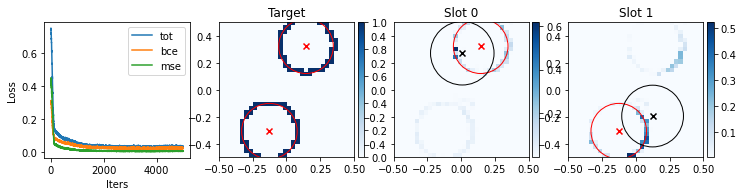

iEvt 1


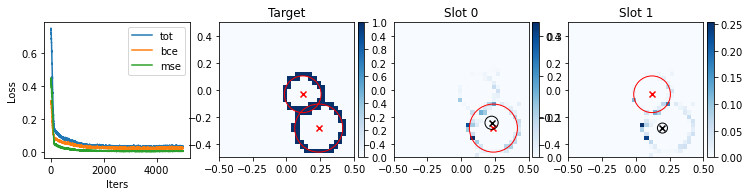

In [48]:
for iEvt in range(2):
# ,bce_i,mse_i in enumerate(zip(l_bce,l_mse)):

    print('iEvt',iEvt)#,', bce',bce_i,'mse',mse_i)  
       
    # losses, mask, att_img, Y_true, Y_pred
    plot_chosen_slots(losses,
                      mask[iEvt].sum(axis=0), 
                      slots_sorted[iEvt].reshape(max_n_rings,*resolution),
                      Y_true_sorted[iEvt],
                      Y_pred_sorted[iEvt])